In [1]:
import os
import cv2
import random
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torchvision
from torch import nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
class cfg:

    seed = 29
    random_state = 29

    epochs = 5
    batch_size = 8

    image_folder = 'image_data'

In [3]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    train_split, valid_split = {}, {}
    
    # Creating Train-split
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_split[folder] = num_files
    
    # Creating Test-split
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        valid_split[folder] = num_files  

    print(f'Train split: {len(train_split)}, Valid split: {len(valid_split)}')
    return train_split, valid_split

In [4]:
train, valid = split_dataset(cfg.image_folder)

Train split: 1191, Valid split: 133


In [5]:
class Face_dataset(Dataset):

    def __init__(self, img_directory, folder_split):
        self.img_directory = img_directory
        self.folder_split = folder_split
        
    def __getitem__(self, idx):

        folders = list(self.folder_split.keys())
        folder1 = random.choice(folders)

        path1 = os.path.join(self.img_directory, str(folder1))
        files = list(os.listdir(path1))
        img1_idx = random.randint(0, len(files)-1)
        img_path1 = os.path.join(path1, f"{img1_idx}.jpg")
        img1 = Image.open(img_path1)

        if idx % 2 == 0:
            img2_idx = random.randint(0, len(files)-1)
            while img2_idx == img1_idx:
                img2_idx = random.randint(0, len(files)-1)
            img_path2 = os.path.join(path1, f"{img2_idx}.jpg")
            img2 = Image.open(img_path2)
            target = torch.tensor(1, dtype=torch.float)
        else:
            folder2 = random.choice(folders)
            while folder2 == folder1:
                folder2 = random.choice(folders)
            path2 = os.path.join(self.img_directory, str(folder2))
            files2 = list(os.listdir(path2))
            img2_idx = random.randint(0, len(files2)-1)
            img_path2 = os.path.join(path2, f"{img2_idx}.jpg")
            img2 = Image.open(img_path2)
            target = torch.tensor(0, dtype=torch.float)

        img1 = T.ToTensor()(img1)
        img2 = T.ToTensor()(img2)
            
        return img1, img2, target
    
    def __len__(self):
        return len(self.folder_split)

In [6]:
train_dataset = Face_dataset(cfg.image_folder, train)
valid_dataset = Face_dataset(cfg.image_folder, valid)

In [7]:
train_loader = DataLoader(train_dataset,
                         batch_size = cfg.batch_size,
                         shuffle = True,
                         num_workers = 0)

valid_loader = DataLoader(valid_dataset,
                         batch_size = cfg.batch_size,
                         shuffle = False,
                         num_workers = 0)

tensor(1.)


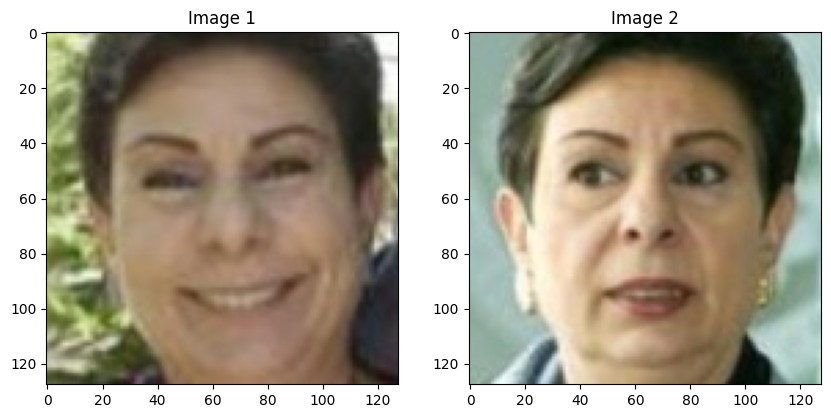

In [8]:
img1, img2, target = train_dataset.__getitem__(2)
img1 = img1.permute(1,2,0)
img2 = img2.permute(1,2,0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(img1)
axes[0].set_title('Image 1')  

axes[1].imshow(img2)
axes[1].set_title('Image 2')  

print(target)

plt.show()

In [9]:
class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()

        self.resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights)
        out_fea = list(self.resnet.modules())[-1].out_features

        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_fea, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 2),
            )

    def get_embeddings(self, x):
        out = self.resnet(x)
        out = out.view(out.shape[0], -1)
        out = self.cls_head(out)
        return out

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.get_embeddings(input1)
        output2 = self.get_embeddings(input2)
        #print(output1, output2)
        
        return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    """

    def __init__(self, margin=5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-target) * torch.pow(euclidean_distance, 2) +
                                      (target) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive, euclidean_distance

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = SiameseNet()

criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [12]:
def train(model, device, dataloader, optimizer, criterion):
    model.to(device)
    model.train()
    epoch_loss = 0 
    torch.manual_seed(42)
    
    for img1, img2, target in tqdm(dataloader, total=len(dataloader)):
        img1, img2, target = img1.to(device), img2.to(device), target.to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss, _ = criterion(output1, output2, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    train_loss = epoch_loss / len(dataloader)
    return train_loss

In [13]:
epochs = 15
for epoch in range(1, epochs+ 1):
    loss = train(model, device, train_loader, optimizer, criterion)
    print(f"Epoch: {epoch}, Train los: {loss}\n")
    
torch.save(model.state_dict(), f"c_model_epoch_{epochs}.pth")

100%|██████████| 298/298 [00:10<00:00, 29.72it/s]


Epoch: 1, Train los: 2.793029687348628



100%|██████████| 298/298 [00:07<00:00, 37.75it/s]


Epoch: 2, Train los: 2.7141439323657313



100%|██████████| 298/298 [00:08<00:00, 36.16it/s]


Epoch: 3, Train los: 2.708060345393699



100%|██████████| 298/298 [00:08<00:00, 36.45it/s]


Epoch: 4, Train los: 2.732396610031192



100%|██████████| 298/298 [00:08<00:00, 35.30it/s]


Epoch: 5, Train los: 2.624576139970114



100%|██████████| 298/298 [00:08<00:00, 36.04it/s]


Epoch: 6, Train los: 2.4935102853799025



100%|██████████| 298/298 [00:08<00:00, 36.14it/s]


Epoch: 7, Train los: 2.3807370082644006



100%|██████████| 298/298 [00:08<00:00, 36.43it/s]


Epoch: 8, Train los: 2.1728705995834914



100%|██████████| 298/298 [00:07<00:00, 37.34it/s]


Epoch: 9, Train los: 1.6996603575128837



100%|██████████| 298/298 [00:08<00:00, 36.92it/s]


Epoch: 10, Train los: 0.8324290530087314



100%|██████████| 298/298 [00:08<00:00, 36.73it/s]


Epoch: 11, Train los: 0.2825599122286974



100%|██████████| 298/298 [00:08<00:00, 36.56it/s]


Epoch: 12, Train los: 0.1295789265233614



100%|██████████| 298/298 [00:08<00:00, 36.92it/s]


Epoch: 13, Train los: 0.11735655771050287



100%|██████████| 298/298 [00:08<00:00, 37.13it/s]


Epoch: 14, Train los: 0.12958949903805972



100%|██████████| 298/298 [00:08<00:00, 37.06it/s]


Epoch: 15, Train los: 0.15509742191734527



In [14]:
chkpt_path = 'c_model_epoch_15.pth'
chkpt = torch.load(chkpt_path)
model.load_state_dict(chkpt)

<All keys matched successfully>

In [19]:
def get_dissimilarities(model, device, criterion):
    model.eval()
    torch.manual_seed(42)

    with torch.no_grad():
        
        img1, img2, target = valid_dataset[3]
        img1 = img1.reshape(1, 3, 128, 128)
        img2 = img2.reshape(1, 3, 128, 128)
        img1, img2, target = img1.to(device), img2.to(device), target.to(device)
        
        out1, out2 = model(img1, img2)
        _, dist = criterion(out1, out2, target)

    return img1, img2, dist

In [20]:
img1, img2, dist = get_dissimilarities(model, device, criterion)

In [21]:
def display_eval_results(images1, images2, score):
    distance = score.cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    plt.subplot(131)
    plt.imshow(images1[0].cpu().numpy().transpose(1,2,0))  
    plt.title("Image 1")
    plt.subplot(132)
    plt.imshow(images2[0].cpu().numpy().transpose(1,2,0))  
    plt.title("Image 2")
    plt.suptitle(f"Distance: {distance:.4f}")
    plt.show()

In [ ]:
display_eval_results(img1, img2, target)